[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/Tulin206/Lecture_HZDR/blob/main/CNN/Hyperparameter.ipynb)

# Artificial Neural Network Implementation with Hyperparameter Tuning
This notebook demonstrates how to build and tune a neural network for customer churn prediction.


## Part 1 - Data Preprocessing
We'll start by importing necessary libraries and preparing our data.


### Importing Required Libraries
Import necessary Python libraries for data manipulation, visualization, and machine learning.


In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


### Importing Machine Learning Libraries
Import specific libraries for model training, preprocessing, and evaluation.


In [2]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix


### Importing Deep Learning Libraries
Import TensorFlow and related libraries for building neural networks.


In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasClassifier


### Loading and Initial Data Processing
Load the dataset and select relevant features.


In [4]:
# Importing the dataset
dataset = pd.read_csv('Churn_Modelling.csv')
X = dataset.iloc[:, 3:13]
y = dataset.iloc[:, 13]


### Handling Categorical Variables
Convert categorical variables (Geography and Gender) into dummy variables.


In [5]:
#Create dummy variables
geography=pd.get_dummies(X["Geography"],drop_first=True)
gender=pd.get_dummies(X['Gender'],drop_first=True)


### Combining Processed Features
Concatenate the dummy variables with the main feature set.


In [6]:
X=pd.concat([X,geography,gender],axis=1)


### Feature Cleanup
Remove original categorical columns after creating dummy variables.


In [7]:
## Drop Unnecessary columns
X=X.drop(['Geography','Gender'],axis=1)


### Data Splitting
Split the data into training and testing sets.


In [8]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


### Feature Scaling
Standardize the features to have zero mean and unit variance.


In [9]:
# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


## Part 2 - Model Creation and Hyperparameter Tuning
Define the model architecture and setup hyperparameter tuning.


### Model Architecture Definition
Define a function to create the neural network with configurable layers and activation functions.


In [10]:
def create_model(layers_list, activation, n_features):
    """
    layers_list : e.g. [40, 20]  -> two hidden layers: 40 neurons then 20 neurons
    activation  : e.g. "relu" or "sigmoid" for hidden layers
    n_features  : number of input features (X_train.shape[1])
    """

    model = keras.Sequential()

    # 1) Tell Keras the input size (modern way: an explicit Input layer)
    model.add(layers.Input(shape=(n_features,)))

    # 2) Hidden layers (loop through your list)
    for nodes in layers_list:
        model.add(layers.Dense(nodes))  # Dense = fully-connected layer
        model.add(layers.Activation(activation))  # your chosen nonlinearity
        model.add(layers.Dropout(0.3))  # turn off 30% units (reduces overfitting)

    # 3) Output layer for binary classification (one probability)
    model.add(layers.Dense(1, kernel_initializer= 'glorot_uniform', activation="sigmoid"))

    # 4) Training setup: optimizer, loss, metric
    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model


### Setting up the Classifier
Create a KerasClassifier wrapper for use with scikit-learn's GridSearchCV.


In [11]:
clf = KerasClassifier(
    model=create_model,
    n_features=X_train.shape[1],  # passed into your function
    verbose=0,
)


### Defining Hyperparameter Grid
Define the different combinations of hyperparameters to try.


In [12]:
# candidates
layers_candidates = [[20], [40, 20], [45, 30, 15]]
activations = ['sigmoid', 'relu']


In [13]:
# ✅ Note the model__ prefix for arguments to create_model
param_grid = {
    "model__layers_list": layers_candidates,
    "model__activation": activations,
    "batch_size": [128, 256],
    "epochs": [30],
}


### Setting up Grid Search
Initialize GridSearchCV with our model and parameter grid.


In [14]:
grid = GridSearchCV(estimator=clf, param_grid=param_grid,cv=5)


### Training the Model
Perform grid search to find the best hyperparameters.


In [15]:
grid_result = grid.fit(X_train, y_train)
print("Best params:", grid_result.best_params_)
print("Best score:", grid_result.best_score_)


Best params: {'batch_size': 128, 'epochs': 30, 'model__activation': 'relu', 'model__layers_list': [45, 30, 15]}
Best score: 0.8551250000000001


### Model Evaluation
Evaluate the best model on the test set.


In [16]:
# Evaluate on test set
best_clf = grid.best_estimator_
test_acc = best_clf.score(X_test, y_test)
print("Test accuracy:", test_acc)


Test accuracy: 0.8615


### Making Predictions
Generate predictions using the best model.


In [17]:
pred_y = grid.predict(X_test)
y_pred = (pred_y > 0.5).astype(int)


### Creating Confusion Matrix
Generate and display the confusion matrix.


In [18]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[1537   58]
 [ 219  186]]


### Calculate Final Accuracy
Compute and display the final accuracy score.


In [19]:
# Calculate the Accuracy
from sklearn.metrics import accuracy_score
score=accuracy_score(y_pred,y_test)
print("Accuracy:", score)


Accuracy: 0.8615


### Visualizing Results
Create a heatmap visualization of the confusion matrix.


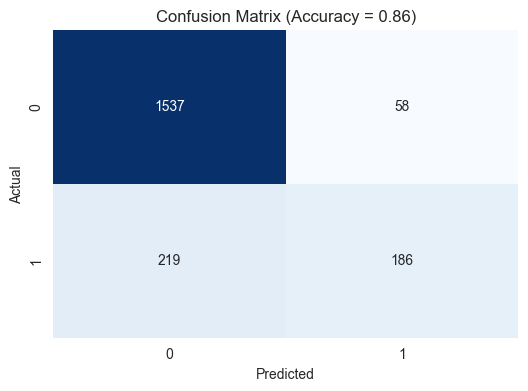

In [20]:
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Accuracy = {score:.2f})')
plt.show()
